Install PySpark & Other Libraries

In [1]:
!pip install pyspark matplotlib seaborn numpy wordcloud

     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 316.9/316.9 MB 1.3 MB/s eta 0:00:00
  Preparing metadata (setup.py) ... done
  Created wheel for pyspark: filename=pyspark-3.5.0-py2.py3-none-any.whl size=317425345 sha256=0b376107fb0e868ee09c93d6997d7e62113ab0aa45815a2d921cf1f3ac5532ab
  Stored in directory: /root/.cache/pip/wheels/41/4e/10/c2cf2467f71c678cfc8a6b9ac9241e5e44a01940da8fbb17fc
Successfully built pyspark


Import Libraries

In [ ]:
from pyspark.sql import SparkSession
from pyspark.sql.functions import concat_ws, col
from pyspark.ml.feature import StringIndexer, VectorAssembler, StandardScaler
from pyspark.ml.classification import LogisticRegression, GBTClassifier
from pyspark.ml import Pipeline
from pyspark.ml.evaluation import BinaryClassificationEvaluator, MulticlassClassificationEvaluator
from pyspark.ml.clustering import KMeans
from sklearn.metrics import roc_curve, precision_recall_curve
import pandas as pd
import matplotlib.pyplot as plt
import seaborn as sns
import numpy as np
from wordcloud import WordCloud, STOPWORDS
from PIL import Image
from collections import Counter

Initialize Spark Session

In [ ]:
spark = SparkSession.builder.appName("WineSpiritsRecommendation").getOrCreate()

Import Dataset

In [ ]:
file_path = "MSML651_ProjectDatasetCSV_MarmoThomas.csv"
df = spark.read.csv(file_path, header=True, inferSchema=True)

Data Validation

In [ ]:
df.show(10)  # Print first 10 rows
df.printSchema()  # Print schema
print(f"Number of rows: {df.count()}\n") # Count number of rows
for col_name in df.columns: # Check for missing values
    missing_count = df.filter(col(col_name).isNull()).count()
    print(f"Missing values in {col_name}: {missing_count}")

+-------------+----------+--------+---------+--------------------+------+-------+---------------+------------------+-----------+----------+----------+-----------+----------+
|  CUSTOMER_ID|      DATE|PURCHASE|  PRODUCT|        PRODUCT_NAME|DIRECT| DEPT_1|         DEPT_2|            DEPT_3|     CHAR_1|    CHAR_2|UNIT_PRICE|MARGIN_RATE|POPULARITY|
+-------------+----------+--------+---------+--------------------+------+-------+---------------+------------------+-----------+----------+----------+-----------+----------+
|8000020000000| 6/17/2023|       1| 94641750|Kim Crawford Sauv...|     0|   Wine|     White Wine|   Sauvignon Blanc|     Citrus|Grapefruit|     20.99|       0.04|      0.24|
|8000020000000| 6/30/2023|       1|239796750|Ch de Laubade 21Y...|     1|Spirits|Brandy & Cognac|          Armagnac|Dried Fruit|   Caramel|    120.99|       0.42|      0.06|
|8000020000000|12/22/2022|       1|127093750|Monkey Shoulder S...|     0|Spirits|         Scotch|    Blended Scotch|    Apricot|  

Visualization

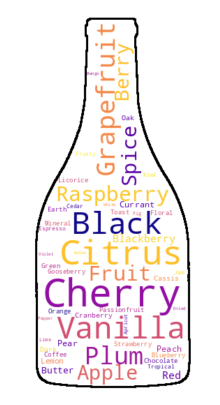

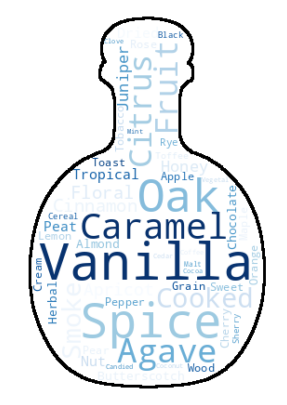

In [ ]:
# Define datasets for wine and spirits, based off of high level department
df_wine = df.filter(df.DEPT_1 == 'Wine')
df_spirits = df.filter(df.DEPT_1 == 'Spirits')

# Wordcloud
def generate_word_cloud(data, mask_image, colormap='viridis'):

    # Generate wordcloud
    text = ' '.join(data.select('CHAR_1', 'CHAR_2').rdd.flatMap(lambda x: x).collect())
    words = text.split()
    word_frequencies = Counter(words)
    mask = np.array(Image.open(mask_image))
    mask = 255 - mask
    wordcloud = WordCloud(
        background_color="white", max_words=50, width=800, height=400,
        mask=mask, contour_width=4, contour_color='black',
        colormap=colormap
    ).generate_from_frequencies(word_frequencies)

    # Plot wordcloud
    plt.figure(figsize=(10, 5))
    plt.imshow(wordcloud, interpolation='bilinear')
    plt.axis('off')
    plt.show()

# Plot the characteristics of wine and spirits into wordclouds in relevant shapes
generate_word_cloud(df_wine, 'MSML651_BottlePinotWide_MarmoThomas.png', colormap='plasma')
generate_word_cloud(df_spirits, 'MSML651_BottleTequila_MarmoThomas.png', colormap='Blues_r')

Convert String Attributes to Integers & Logistic Regression Pipeline

In [ ]:
# String Indexing for categorical features
categorical_features = ['DEPT_1', 'DEPT_2', 'DEPT_3', 'CHAR_1', 'CHAR_2']
indexers = [StringIndexer(inputCol=column, outputCol=column + "_index", handleInvalid="keep") for column in categorical_features]

# Assemble features into a vector
feature_columns = ['DEPT_1_index', 'DEPT_2_index', 'DEPT_3_index', 'CHAR_1_index', 'CHAR_2_index', 'UNIT_PRICE', 'MARGIN_RATE', 'POPULARITY']
assembler = VectorAssembler(inputCols=feature_columns, outputCol="features")

# Create a logistic regression machine learning pipeline
logistic_regression = LogisticRegression(featuresCol="features", labelCol="PURCHASE")
pipeline = Pipeline(stages=indexers + [assembler, logistic_regression])

# Show the first 10 rows of the transformed DataFrame
transformed_data = pipeline.fit(df).transform(df)
transformed_data.show(10)

+-------------+----------+--------+---------+--------------------+------+-------+---------------+------------------+-----------+----------+----------+-----------+----------+------------+------------+------------+------------+------------+--------------------+--------------------+--------------------+----------+
|  CUSTOMER_ID|      DATE|PURCHASE|  PRODUCT|        PRODUCT_NAME|DIRECT| DEPT_1|         DEPT_2|            DEPT_3|     CHAR_1|    CHAR_2|UNIT_PRICE|MARGIN_RATE|POPULARITY|DEPT_1_index|DEPT_2_index|DEPT_3_index|CHAR_1_index|CHAR_2_index|            features|       rawPrediction|         probability|prediction|
+-------------+----------+--------+---------+--------------------+------+-------+---------------+------------------+-----------+----------+----------+-----------+----------+------------+------------+------------+------------+------------+--------------------+--------------------+--------------------+----------+
|8000020000000| 6/17/2023|       1| 94641750|Kim Crawford Sau

Split The Dataset & Machine Learning with PySpark Pipeline

In [ ]:
(train_data, test_data) = df.randomSplit([0.8, 0.2])
model = pipeline.fit(train_data)

Evaluate Logistic Regression Model Performance

In [ ]:
# Make purchasing predictions
predictions = model.transform(test_data)

# Area Under Receiver Operating Characteristic (ROC) Curve
evaluator_roc = BinaryClassificationEvaluator(labelCol="PURCHASE", metricName="areaUnderROC")
area_under_roc = evaluator_roc.evaluate(predictions)
print(f"Area Under ROC Curve: {area_under_roc}")

# Accuracy
evaluator_acc = MulticlassClassificationEvaluator(labelCol="PURCHASE", metricName="accuracy")
accuracy = evaluator_acc.evaluate(predictions)
print(f"Accuracy: {accuracy}")

# Precision
evaluator_precision = MulticlassClassificationEvaluator(labelCol="PURCHASE", metricName="weightedPrecision")
precision = evaluator_precision.evaluate(predictions)
print(f"Precision: {precision}")

# Recall
evaluator_recall = MulticlassClassificationEvaluator(labelCol="PURCHASE", metricName="weightedRecall")
recall = evaluator_recall.evaluate(predictions)
print(f"Recall: {recall}")

# F1 Score
evaluator_f1 = MulticlassClassificationEvaluator(labelCol="PURCHASE", metricName="f1")
f1_score = evaluator_f1.evaluate(predictions)
print(f"F1 Score: {f1_score}")

Area Under ROC Curve: 0.7470732641814327
Accuracy: 0.7253502583240264
Precision: 0.7142710947722308
Recall: 0.7253502583240264
F1 Score: 0.7046812279365566


Visualization

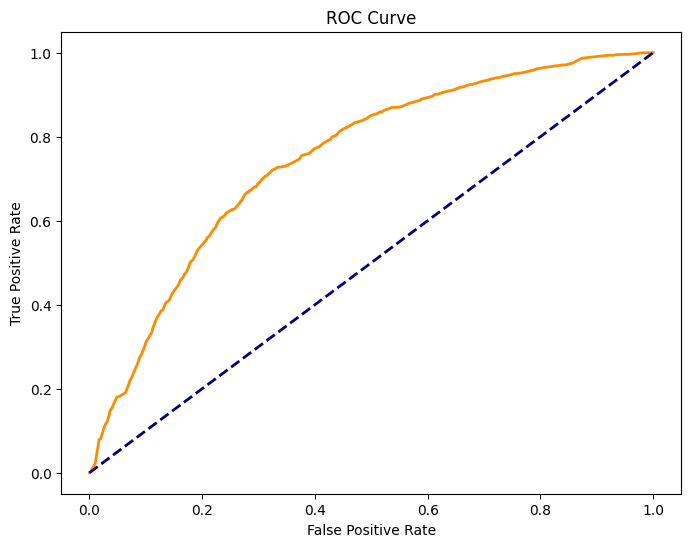

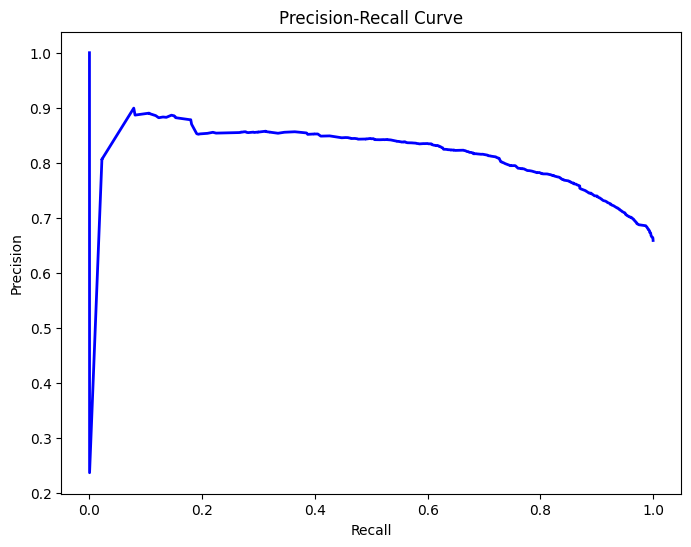

In [ ]:
# Plot ROC Curve
def plot_roc_curve(predictions):
    y_true = [float(row.PURCHASE) for row in predictions.select('PURCHASE').collect()]
    y_scores = [float(row.probability[1]) for row in predictions.select('probability').collect()]

    fpr, tpr, _ = roc_curve(y_true, y_scores)
    plt.figure(figsize=(8, 6))
    plt.plot(fpr, tpr, color='darkorange', lw=2)
    plt.plot([0, 1], [0, 1], color='navy', lw=2, linestyle='--')
    plt.xlabel('False Positive Rate')
    plt.ylabel('True Positive Rate')
    plt.title('ROC Curve')
    plt.show()

# Plot Precision-Recall Curve
def plot_precision_recall_curve(predictions):
    y_true = [float(row.PURCHASE) for row in predictions.select('PURCHASE').collect()]
    y_scores = [float(row.probability[1]) for row in predictions.select('probability').collect()]

    precision, recall, _ = precision_recall_curve(y_true, y_scores)
    plt.figure(figsize=(8, 6))
    plt.plot(recall, precision, color='blue', lw=2)
    plt.xlabel('Recall')
    plt.ylabel('Precision')
    plt.title('Precision-Recall Curve')
    plt.show()

plot_roc_curve(predictions)
plot_precision_recall_curve(predictions)

Gradient Boost Using PySpark

Area Under ROC Curve: 0.7908916098116312
Accuracy: 0.7560131840592738
Precision: 0.7486783585945623
Recall: 0.7560131840592739
F1 Score: 0.7440810173559204


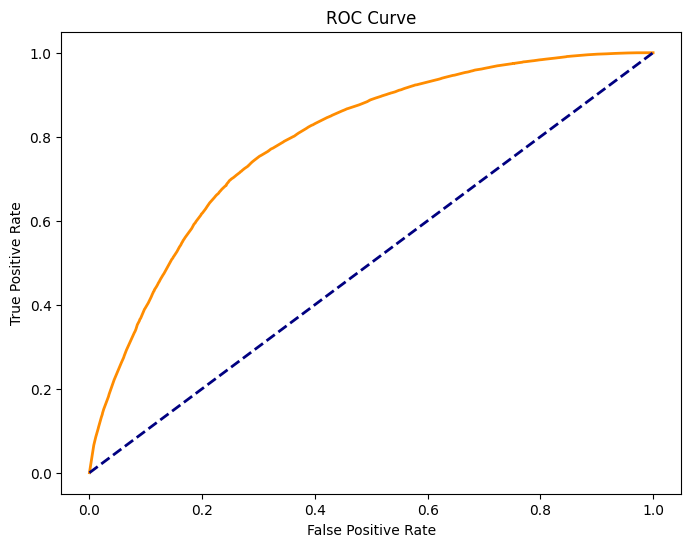

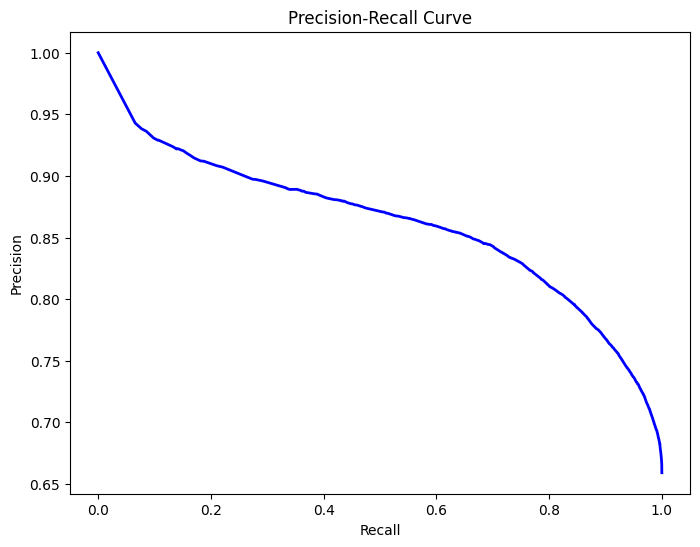

In [ ]:
# Create pipeline with the gradient boosting classifier
gbt_classifier = GBTClassifier(featuresCol="features", labelCol="PURCHASE", maxIter=10, maxDepth=5, maxBins=300)
pipeline = Pipeline(stages=indexers + [assembler, gbt_classifier])

# Train the model & test
model = pipeline.fit(train_data)
predictions = model.transform(test_data)

# Area Under Receiver Operating Characteristic (ROC) Curve
evaluator_roc = BinaryClassificationEvaluator(labelCol="PURCHASE", metricName="areaUnderROC")
area_under_roc = evaluator_roc.evaluate(predictions)
print(f"Area Under ROC Curve: {area_under_roc}")

# Accuracy
evaluator_acc = MulticlassClassificationEvaluator(labelCol="PURCHASE", metricName="accuracy")
accuracy = evaluator_acc.evaluate(predictions)
print(f"Accuracy: {accuracy}")

# Precision
evaluator_precision = MulticlassClassificationEvaluator(labelCol="PURCHASE", metricName="weightedPrecision")
precision = evaluator_precision.evaluate(predictions)
print(f"Precision: {precision}")

# Recall
evaluator_recall = MulticlassClassificationEvaluator(labelCol="PURCHASE", metricName="weightedRecall")
recall = evaluator_recall.evaluate(predictions)
print(f"Recall: {recall}")

# F1 Score
evaluator_f1 = MulticlassClassificationEvaluator(labelCol="PURCHASE", metricName="f1")
f1_score = evaluator_f1.evaluate(predictions)
print(f"F1 Score: {f1_score}")

# Plot curves
plot_roc_curve(predictions)
plot_precision_recall_curve(predictions)

# Recommendation from User Input

In [ ]:
# User input
user_id = 123456789
user_date = "12/01/2023"
user_purchase = 0
user_input_products = [122089750, 164292750, 163853750]

# Create dataframe from user input
user_input_df = spark.createDataFrame([(user_id, user_date, user_purchase, product_id) for product_id in user_input_products],
                                      ["CUSTOMER_ID", "DATE", "PURCHASE", "PRODUCT"])

# Join user input dataframe on product id
joined_user_input_df = df.join(user_input_df, df.PRODUCT == user_input_df.PRODUCT, "inner")
final_user_input_df = joined_user_input_df.select(user_input_df.CUSTOMER_ID, user_input_df.DATE,
                            user_input_df.PURCHASE, df.PRODUCT, df.PRODUCT_NAME,
                            df.DIRECT, df.DEPT_1, df.DEPT_2, df.DEPT_3,
                            df.CHAR_1, df.CHAR_2, df.UNIT_PRICE, df.MARGIN_RATE,
                            df.POPULARITY).distinct()

final_user_input_df.show()

+-----------+----------+--------+---------+--------------------+------+------+--------+------------------+-------------+-------------+----------+-----------+----------+
|CUSTOMER_ID|      DATE|PURCHASE|  PRODUCT|        PRODUCT_NAME|DIRECT|DEPT_1|  DEPT_2|            DEPT_3|       CHAR_1|       CHAR_2|UNIT_PRICE|MARGIN_RATE|POPULARITY|
+-----------+----------+--------+---------+--------------------+------+------+--------+------------------+-------------+-------------+----------+-----------+----------+
|  123456789|12/01/2023|       0|163853750|Mondavi Prvt Sel ...|     0|  Wine|Red Wine|Cabernet Sauvignon|          Oak|Black Currant|     17.99|       0.07|      0.03|
|  123456789|12/01/2023|       0|164292750|Iter Pinot Noir C...|     1|  Wine|Red Wine|        Pinot Noir|    Blueberry|   Blackberry|     18.99|       0.53|      0.03|
|  123456789|12/01/2023|       0|122089750|Shannon Ridge Cab...|     0|  Wine|Red Wine|Cabernet Sauvignon|Black Currant|   Blackberry|     14.99|       0.1

In [ ]:
# Predict the liklihood of which products are most likely to be purchased
predictions = model.transform(final_user_input_df)
predictions.show()

+-----------+----------+--------+---------+--------------------+------+------+--------+------------------+-------------+-------------+----------+-----------+----------+------------+------------+------------+------------+------------+--------------------+--------------------+--------------------+----------+
|CUSTOMER_ID|      DATE|PURCHASE|  PRODUCT|        PRODUCT_NAME|DIRECT|DEPT_1|  DEPT_2|            DEPT_3|       CHAR_1|       CHAR_2|UNIT_PRICE|MARGIN_RATE|POPULARITY|DEPT_1_index|DEPT_2_index|DEPT_3_index|CHAR_1_index|CHAR_2_index|            features|       rawPrediction|         probability|prediction|
+-----------+----------+--------+---------+--------------------+------+------+--------+------------------+-------------+-------------+----------+-----------+----------+------------+------------+------------+------------+------------+--------------------+--------------------+--------------------+----------+
|  123456789|12/01/2023|       0|163853750|Mondavi Prvt Sel ...|     0|  Win